# BERT Text Classifier for IMDb Movie Reviews

A comprehensive implementation of a BERT-based text classifier for sentiment analysis using PyTorch and the Transformers library.

**Features:**
- Pre-trained BERT model for text classification
- IMDb movie reviews dataset (25,000 training + 25,000 test samples)
- Comprehensive evaluation metrics
- Training visualization and analysis
- Example predictions with confidence scores

**🤖 Generated by [Claude Code](https://claude.ai/code)**

## 1. Environment Setup and Imports

In [1]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision transformers datasets scikit-learn matplotlib seaborn pandas numpy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Device configuration
def get_device():    
    if torch.backends.mps.is_available():
        # device = torch.device('mps')
        device = torch.device('cpu')
        print("Detected Apple Silicon MPS GPU, however, the model produces NaNs on MPS backend, so, still use CPU")
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print("Using NVIDIA CUDA GPU")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    return device

device = get_device()
print(f"Device: {device}")

Using NVIDIA CUDA GPU
Device: cuda


## 2. Dataset Loading and Preprocessing

In [3]:
def load_imdb_dataset():
    """Load and prepare IMDb dataset"""
    print("Loading IMDb dataset...")
    
    try:
        # Try to load from local cache first
        if os.path.exists('imdb_data.csv'):
            print("Loading cached IMDb data...")
            df = pd.read_csv('imdb_data.csv')
        else:
            # Download IMDb dataset using datasets library
            from datasets import load_dataset
            print("Downloading IMDb dataset from Hugging Face...")
            dataset = load_dataset('imdb')
            
            # Convert to pandas DataFrame
            train_data = dataset['train'].to_pandas()
            test_data = dataset['test'].to_pandas()
            
            # Combine and shuffle
            df = pd.concat([train_data, test_data], ignore_index=True)
            df = df.sample(frac=1, random_state=42).reset_index(drop=True)
            
            # Cache the data
            df.to_csv('imdb_data.csv', index=False)
            print(f"Cached dataset to imdb_data.csv")
        
        print(f"Dataset loaded successfully!")
        print(f"Total samples: {len(df)}")
        print(f"Positive samples: {df['label'].sum()}")
        print(f"Negative samples: {len(df) - df['label'].sum()}")
        
        return df['text'].values, df['label'].values
        
    except ImportError as e:
        print("datasets library not available.")
        # print("Creating synthetic IMDb-like data...")
        raise e
        # return create_synthetic_data()
    except Exception as e:
        print(f"Error loading IMDb dataset.")
        # print("Creating synthetic IMDb-like data...")
        raise e
        # return create_synthetic_data()

# Claude Code generated this code but it does not make sense to continue with synthetic data if the real data set cannot downloaded.
#
# def create_synthetic_data():
#     """Create synthetic movie review data for demonstration"""
#     positive_reviews = [
#         "This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.",
#         "I loved every minute of this film. The cinematography was breathtaking and the story was compelling.",
#         "An incredible masterpiece! The characters were well-developed and the ending was perfect.",
#         "Outstanding performance by all actors. This is definitely one of the best movies I've ever seen.",
#         "Brilliant storytelling and amazing special effects. Highly recommended!",
#         "A wonderful film that kept me on the edge of my seat. Great direction and excellent music.",
#         "This movie exceeded all my expectations. The dialogue was witty and the pacing was perfect.",
#         "Absolutely loved it! The plot twists were unexpected and the acting was phenomenal.",
#         "A true gem of cinema. The emotional depth and visual effects were remarkable.",
#         "Perfect blend of action and drama. The cast delivered outstanding performances."
#     ] * 250  # Repeat to create more samples
#
#     negative_reviews = [
#         "This movie was terrible. The plot made no sense and the acting was awful.",
#         "I couldn't even finish watching this film. It was boring and poorly executed.",
#         "Worst movie I've ever seen. The dialogue was cringe-worthy and the story was predictable.",
#         "A complete waste of time. The characters were one-dimensional and the plot was confusing.",
#         "Poorly directed and badly acted. I want my money back.",
#         "This film was a disaster. The pacing was terrible and the ending was disappointing.",
#         "Absolutely horrible. The special effects were cheap and the story made no sense.",
#         "I fell asleep halfway through. The movie was boring and the characters were unlikeable.",
#         "A terrible film with poor writing and unconvincing performances.",
#         "One of the worst movies ever made. The plot holes were enormous and the acting was wooden."
#     ] * 250  # Repeat to create more samples
#
#     # Combine positive (1) and negative (0) reviews
#     reviews = positive_reviews + negative_reviews
#     labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)
#
#     # Shuffle the data
#     combined = list(zip(reviews, labels))
#     np.random.shuffle(combined)
#     reviews, labels = zip(*combined)
#
#     print(f"Created synthetic dataset with {len(reviews)} samples")
#     return np.array(reviews), np.array(labels)

# Load the dataset
reviews, labels = load_imdb_dataset()

Loading IMDb dataset...


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Cached dataset to imdb_data.csv
Dataset loaded successfully!
Total samples: 50000
Positive samples: 25000
Negative samples: 25000


In [4]:
# Display some sample reviews
print("Sample Reviews:")
print("=" * 80)

for i in range(3):
    sentiment = "Positive" if labels[i] == 1 else "Negative"
    print(f"\n{i+1}. Label: {sentiment}")
    print(f"Review: {reviews[i][:200]}...")
    print("-" * 80)

Sample Reviews:

1. Label: Negative
Review: Forget what I said about Emeril. Rachael Ray is the most irritating personality on the Food Network AND all of television. If you've never seen 30 Minute Meals, then you cannot possibly begin to compr...
--------------------------------------------------------------------------------

2. Label: Negative
Review: Former private eye-turned-security guard ditches his latest droning job and is immediately offered a chance to return to his previous profession. His assignment: to tail a mysterious French woman newl...
--------------------------------------------------------------------------------

3. Label: Negative
Review: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun...
--------------------------------------------------------------------------------


## 3. Custom Dataset Class

In [5]:
class IMDbDataset(Dataset):
    """Custom Dataset for IMDb reviews"""
    
    def __init__(self, reviews, labels, tokenizer, max_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        
        # Tokenize and encode the review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("IMDbDataset class defined successfully!")

IMDbDataset class defined successfully!


## 4. BERT Text Classifier Model

In [6]:
class BERTTextClassifier(nn.Module):
    """BERT-based text classifier for sentiment analysis"""
    
    def __init__(self, n_classes=2, bert_model_name='bert-base-uncased', dropout=0.3):
        super(BERTTextClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        
        # print("\n--- Forward Pass Debugging ---")
        # print(f"Input_ids min: {input_ids.min().item()}, max: {input_ids.max().item()}")
        # print(f"Attention_mask min: {attention_mask.min().item()}, max: {attention_mask.max().item()}")
        
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token representation
        pooled_output = outputs.pooler_output

        # # --- Check pooled_output ---
        # if torch.isnan(pooled_output).any():
        #     print("pooled_output has NaNs! Problem likely in BertModel output.")
        # if torch.isinf(pooled_output).any():
        #     print("pooled_output has Infs! Problem likely in BertModel output.")
        # print(f"Pooled_output min: {pooled_output.min().item():.4f}, max: {pooled_output.max().item():.4f}, mean: {pooled_output.mean().item():.4f}, std: {pooled_output.std().item():.4f}")

        output = self.dropout(pooled_output)

        # # --- Check output_after_dropout ---
        # if torch.isnan(output).any():
        #     print("output_after_dropout has NaNs! Problem likely introduced by dropout.")
        # if torch.isinf(output).any():
        #     print("output_after_dropout has Infs! Problem likely introduced by dropout.")
        # print(f"Output after dropout min: {output.min().item():.4f}, max: {output.max().item():.4f}, mean: {output.mean().item():.4f}, std: {output.std().item():.4f}")

        logits = self.classifier(output)
        
        # # --- Check final logits ---
        # if torch.isnan(logits).any():
        #     print("Final logits have NaNs! Problem likely introduced by classifier (nn.Linear).")
        # if torch.isinf(logits).any():
        #     print("Final logits have Infs! Problem likely introduced by classifier (nn.Linear).")
        # print(f"Logits min: {logits.min().item():.4f}, max: {logits.max().item():.4f}, mean: {logits.mean().item():.4f}, std: {logits.std().item():.4f}")

        return logits

print("BERTTextClassifier model class defined successfully!")

BERTTextClassifier model class defined successfully!


## 5. Training and Evaluation Functions

In [7]:
class MetricsTracker:
    """Track training and validation metrics"""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.epoch_times = []
        self.learning_rates = []
    
    def update(self, train_loss, val_loss, train_acc, val_acc, epoch_time, lr):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accuracies.append(train_acc)
        self.val_accuracies.append(val_acc)
        self.epoch_times.append(epoch_time)
        self.learning_rates.append(lr)

def evaluate_model(model, data_loader, criterion, device):
    """Evaluate the model on given data"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy, all_predictions, all_labels

def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for i, batch in enumerate(data_loader):

        # debugging NaN issue
        # if torch.isnan(batch['input_ids']).any(): print("NaN in input_ids!")
        # if torch.isinf(batch['input_ids']).any(): print("Inf in input_ids!")
        # if torch.isnan(batch['attention_mask']).any(): print("NaN in attention_mask!")
        # if torch.isinf(batch['attention_mask']).any(): print("Inf in attention_mask!")
        # if torch.isnan(batch['label']).any(): print("NaN in labels!")
        # if torch.isinf(batch['label']).any(): print("Inf in labels!")
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask)

        # # --- Add this line for debugging ---
        # print(f"Logits min: {outputs.min().item():.4f}, max: {outputs.max().item():.4f}, mean: {outputs.mean().item():.4f}, std: {outputs.std().item():.4f}")
        # # ----------------------------------

        
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        if i % 5 == 0:
            print(f'  Batch {i}/{len(data_loader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


## 6. Data Preparation and Model Initialization

In [8]:
# Hyperparameters
MAX_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5
BERT_MODEL_NAME = 'bert-base-uncased'

print(f"Hyperparameters:")
print(f"Max Length: {MAX_LENGTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"BERT Model: {BERT_MODEL_NAME}")

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    reviews, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nDataset split:")
print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

Hyperparameters:
Max Length: 512
Batch Size: 16
Epochs: 4
Learning Rate: 2e-05
BERT Model: bert-base-uncased

Dataset split:
Training: 35000 samples
Validation: 7500 samples
Test: 7500 samples


In [9]:
# Initialize tokenizer
print(f"Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

# Create datasets
train_dataset = IMDbDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = IMDbDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = IMDbDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Data loaders created successfully!
Training batches: 2188
Validation batches: 469
Test batches: 469


In [10]:
# Initialize model
print(f"Loading BERT model...")
model = BERTTextClassifier(n_classes=2, bert_model_name=BERT_MODEL_NAME)
model = model.to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Model and optimizer initialized successfully!")
print(f"Total training steps: {total_steps}")

Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Total parameters: 109,483,778
Trainable parameters: 109,483,778
Model and optimizer initialized successfully!
Total training steps: 8752


## 7. Model Training

In [11]:
# Metrics tracker
metrics_tracker = MetricsTracker()

# Training loop
print(f"Starting training...")
print("=" * 50)

best_val_accuracy = 0
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 30)
    
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device
    )
    
    # Validation
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
    
    epoch_time = time.time() - epoch_start_time
    current_lr = scheduler.get_last_lr()[0]
    
    # Update metrics
    metrics_tracker.update(train_loss, val_loss, train_acc, val_acc, epoch_time, current_lr)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_bert_model.pth')
        print("New best model saved!")

total_training_time = time.time() - start_time
print(f"\nTraining completed in {total_training_time/60:.2f} minutes")

Starting training...

Epoch 1/4
------------------------------
  Batch 0/2188, Loss: 0.7346
  Batch 5/2188, Loss: 0.5424
  Batch 10/2188, Loss: 0.5938
  Batch 15/2188, Loss: 0.6368
  Batch 20/2188, Loss: 0.6484
  Batch 25/2188, Loss: 0.5177
  Batch 30/2188, Loss: 0.4722
  Batch 35/2188, Loss: 0.4040
  Batch 40/2188, Loss: 0.4813
  Batch 45/2188, Loss: 0.4739
  Batch 50/2188, Loss: 0.2966
  Batch 55/2188, Loss: 0.5886
  Batch 60/2188, Loss: 0.1350
  Batch 65/2188, Loss: 0.3569
  Batch 70/2188, Loss: 0.2602
  Batch 75/2188, Loss: 0.4498
  Batch 80/2188, Loss: 0.3550
  Batch 85/2188, Loss: 0.3204
  Batch 90/2188, Loss: 0.4975
  Batch 95/2188, Loss: 0.3627
  Batch 100/2188, Loss: 0.3387
  Batch 105/2188, Loss: 0.4259
  Batch 110/2188, Loss: 0.5464
  Batch 115/2188, Loss: 0.1703
  Batch 120/2188, Loss: 0.4604
  Batch 125/2188, Loss: 0.4948
  Batch 130/2188, Loss: 0.2567
  Batch 135/2188, Loss: 0.3875
  Batch 140/2188, Loss: 0.4044
  Batch 145/2188, Loss: 0.3051
  Batch 150/2188, Loss: 0.128

## 8. Model Evaluation

In [12]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_bert_model.pth'))

# Test evaluation
print("Evaluating on test set...")
test_loss, test_acc, test_predictions, test_labels = evaluate_model(
    model, test_loader, criterion, device
)

# Calculate detailed metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_predictions, average='weighted'
)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Classification report
print(f"\nDetailed Classification Report:")
class_names = ['Negative', 'Positive']
print(classification_report(test_labels, test_predictions, 
                          target_names=class_names))

Evaluating on test set...

Final Test Results:
Test Loss: 0.2101
Test Accuracy: 0.9395
Test Precision: 0.9395
Test Recall: 0.9395
Test F1-Score: 0.9395

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      3750
    Positive       0.94      0.94      0.94      3750

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500



## 9. Visualization and Analysis

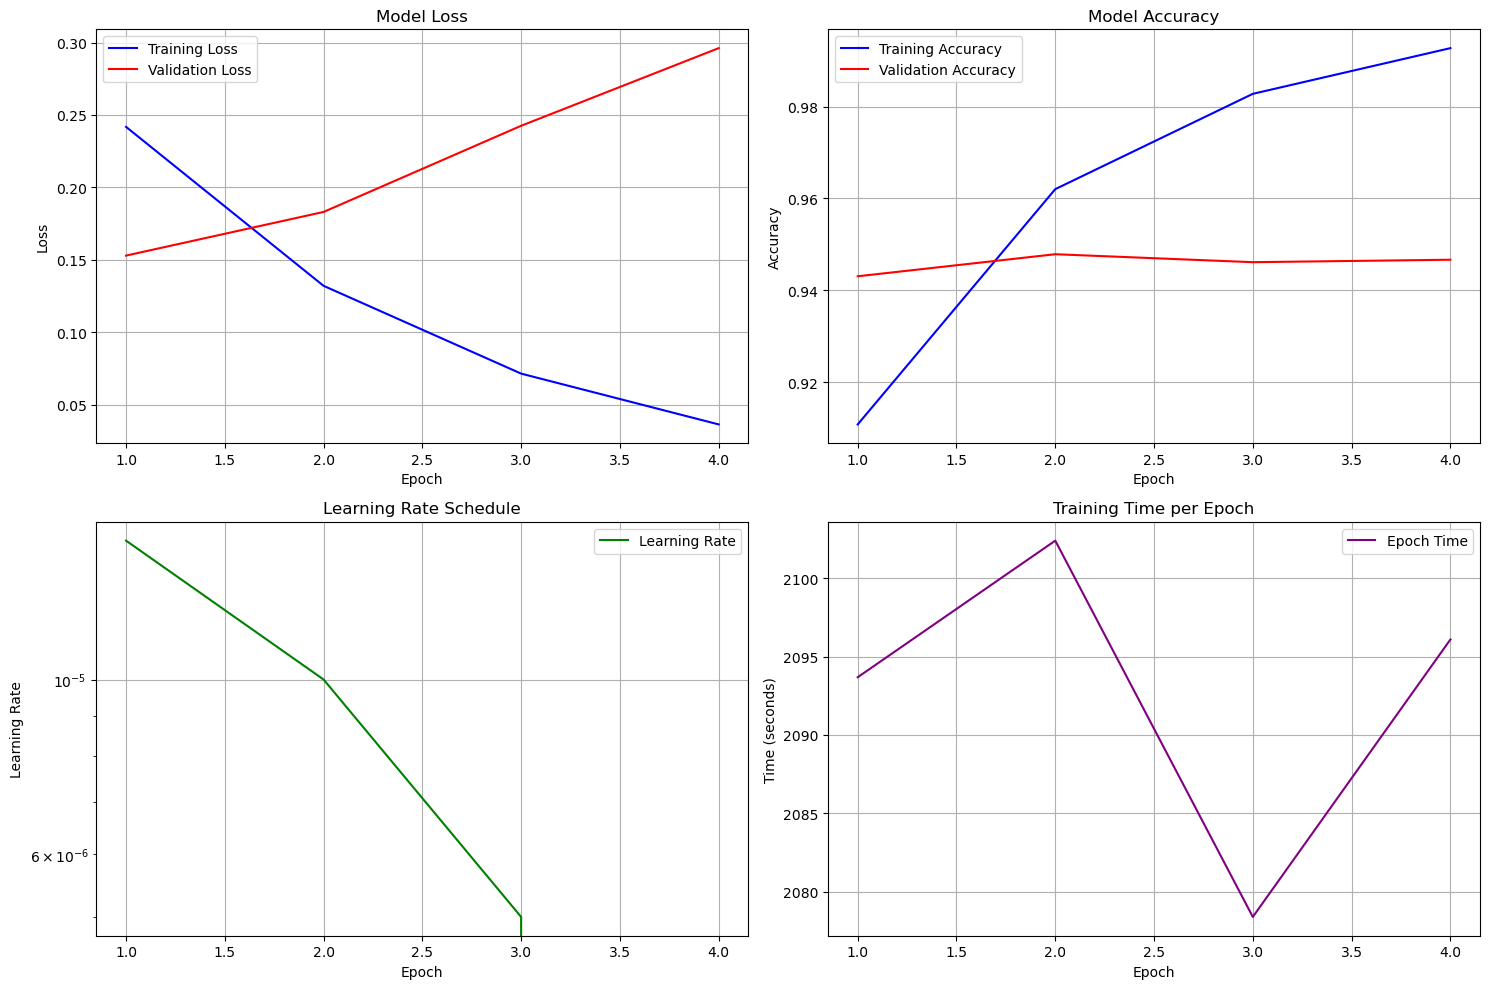

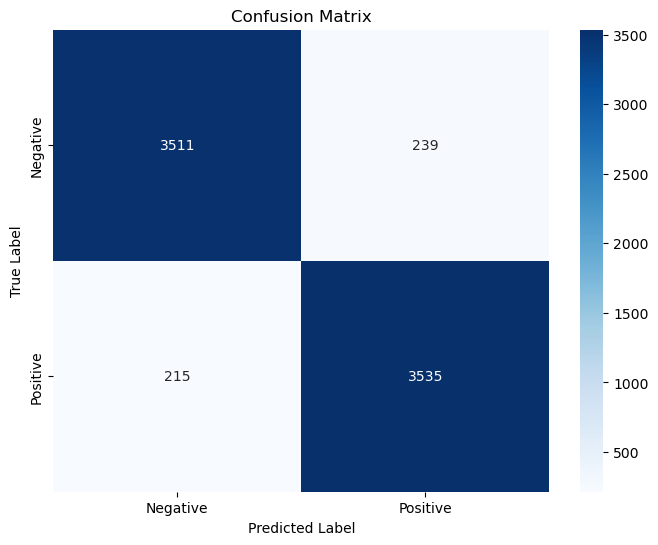

In [13]:
def plot_training_history(metrics_tracker):
    """Plot training metrics"""
    epochs = range(1, len(metrics_tracker.train_losses) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    ax1.plot(epochs, metrics_tracker.train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, metrics_tracker.val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy
    ax2.plot(epochs, metrics_tracker.train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, metrics_tracker.val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Learning Rate
    ax3.plot(epochs, metrics_tracker.learning_rates, 'g-', label='Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.legend()
    ax3.grid(True)
    ax3.set_yscale('log')
    
    # Training Time
    ax4.plot(epochs, metrics_tracker.epoch_times, 'purple', label='Epoch Time')
    ax4.set_title('Training Time per Epoch')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Time (seconds)')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('bert_training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('bert_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot results
plot_training_history(metrics_tracker)
plot_confusion_matrix(test_labels, test_predictions, class_names)

## 10. Example Predictions

In [14]:
def predict_sentiment(model, tokenizer, text, device, max_length=512):
    """Predict sentiment for a single text"""
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        predictions = torch.softmax(outputs, dim=1)
    
    confidence = torch.max(predictions, dim=1)[0].item()
    predicted_class = torch.argmax(predictions, dim=1).item()
    
    return predicted_class, confidence

# Example predictions
print(f"Example Predictions:")
print("=" * 50)

test_examples = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Terrible film, waste of time. Poor acting and boring plot.",
    "An okay movie, nothing special but not bad either.",
    "Brilliant cinematography and outstanding performances by all actors.",
    "I fell asleep halfway through. Very disappointing."
]

for i, text in enumerate(test_examples, 1):
    pred_class, confidence = predict_sentiment(model, tokenizer, text, device)
    sentiment = "Positive" if pred_class == 1 else "Negative"
    print(f"\n{i}. Review: {text}")
    print(f"   Predicted: {sentiment} (Confidence: {confidence:.3f})")

Example Predictions:

1. Review: This movie was absolutely fantastic! I loved every minute of it.
   Predicted: Positive (Confidence: 0.996)

2. Review: Terrible film, waste of time. Poor acting and boring plot.
   Predicted: Negative (Confidence: 1.000)

3. Review: An okay movie, nothing special but not bad either.
   Predicted: Negative (Confidence: 0.991)

4. Review: Brilliant cinematography and outstanding performances by all actors.
   Predicted: Positive (Confidence: 0.997)

5. Review: I fell asleep halfway through. Very disappointing.
   Predicted: Negative (Confidence: 0.995)


## 11. Summary and Results

In [15]:
print(f"\n🎉 BERT Text Classification Pipeline Completed Successfully!")
print(f"📊 Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"⏱️ Total Training Time: {total_training_time/60:.2f} minutes")
print(f"\n📈 Final Results Summary:")
print(f"   • Model: {BERT_MODEL_NAME}")
print(f"   • Dataset: IMDb Movie Reviews")
print(f"   • Test Accuracy: {test_acc:.4f}")
print(f"   • Test F1-Score: {f1:.4f}")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Training Device: {device}")

print(f"\n💾 Saved Files:")
print(f"   • best_bert_model.pth - Trained model weights")
print(f"   • bert_training_metrics.png - Training visualization")
print(f"   • bert_confusion_matrix.png - Confusion matrix")
print(f"   • imdb_data.csv - Cached dataset (if downloaded)")


🎉 BERT Text Classification Pipeline Completed Successfully!
📊 Best Validation Accuracy: 0.9479
⏱️ Total Training Time: 139.53 minutes

📈 Final Results Summary:
   • Model: bert-base-uncased
   • Dataset: IMDb Movie Reviews
   • Test Accuracy: 0.9395
   • Test F1-Score: 0.9395
   • Total Parameters: 109,483,778
   • Training Device: cuda

💾 Saved Files:
   • best_bert_model.pth - Trained model weights
   • bert_training_metrics.png - Training visualization
   • bert_confusion_matrix.png - Confusion matrix
   • imdb_data.csv - Cached dataset (if downloaded)
